In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers, layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# LOAD DATA

In [2]:
# Loading the dataset - on kaggle notebook

x_data = np.load('../input/273-intro-to-prac-ml-summer2021/x_data_273.npy')
y_data = np.load('../input/273-intro-to-prac-ml-summer2021/y_data_273.npy')
x_test = np.load('../input/273-intro-to-prac-ml-summer2021/x_test_273.npy')

In [3]:
x_data.shape

(32000, 28, 56)

In [4]:
y_data.shape

(32000,)

In [5]:
x_test.shape

(10000, 28, 56)

# MISSING VALUE

In [6]:
np.isnan(x_data).any()

False

In [7]:
np.isnan(x_test).any()

False

In [8]:
np.isnan(y_data).any()

False

In [9]:
print(y_data)

[8 6 5 ... 6 1 1]


In [10]:
x_data=np.expand_dims(x_data,axis=-1)
x_data.shape

(32000, 28, 56, 1)

# SHUFFLE THE DATA SET

### In order to avoid problems with the validation set due to the ordering of the data set in the subsequent "validation_split" method, the data set is shuffled with "np.random.shuffle()".

In [11]:
index=np.arange(32000)
np.random.shuffle(index)
x_data=x_data[index,:,:,:]#X_train是训练集，y_train是训练标签
y_data=y_data[index]

In [12]:
x_train = x_data
x_test1 = np.expand_dims(x_test,axis=-1)

# METHOD of VGG（NOT GOOD）

In [13]:
'''
// IMG_OUT = cv2.cvtColor(IMG_IN, cv2.COLOR_GRAY2RGB)
x_datanew = []
for x in x_train: 
    x1 = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
    x_datanew.append(x1)
x_testnew = []
for x in x_test1: 
    x2 = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
    x_testnew.append(x2)
#plt.imshow(x_datanew[0])

x_datanew = np.array(x_datanew)
x_testnew = np.array(x_testnew)
x_datanew.shape

conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False,
input_shape=(32, 56, 3))

model = keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    # layers.Dropout(0.5),
    layers.Dense(10, activation="sigmoid")
])
'''

'\n// IMG_OUT = cv2.cvtColor(IMG_IN, cv2.COLOR_GRAY2RGB)\nx_datanew = []\nfor x in x_train: \n    x1 = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)\n    x_datanew.append(x1)\nx_testnew = []\nfor x in x_test1: \n    x2 = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)\n    x_testnew.append(x2)\n#plt.imshow(x_datanew[0])\n\nx_datanew = np.array(x_datanew)\nx_testnew = np.array(x_testnew)\nx_datanew.shape\n\nconv_base = keras.applications.vgg16.VGG16(\nweights="imagenet",\ninclude_top=False,\ninput_shape=(32, 56, 3))\n\nmodel = keras.Sequential([\n    data_augmentation,\n    layers.experimental.preprocessing.Rescaling(1./255),\n    conv_base,\n    layers.Flatten(),\n    layers.Dense(256, activation="relu"),\n    layers.Dense(128, activation="relu"),\n    # layers.Dropout(0.5),\n    layers.Dense(10, activation="sigmoid")\n])\n'

# ENHANCED TRAIN SET

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,    
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,          # ZCA Whitening
        rotation_range=10,            # Randomly rotate training images by 10 degrees
        zoom_range = 0.1,             # Randomly scale some training images by 10%
        width_shift_range=0.1,        # Move the image horizontally by 10% of the width
        height_shift_range=0.1,       # Move the image vertically by 10% of the height
        horizontal_flip=False,        # BAN vertical and horizontal flipping
        vertical_flip=False)          # It may lead to misclassification of symmetrical numbers(such as 6 and 9)
datagen.fit(x_train)

# CNN BUILD

In [15]:
inputs = keras.Input(shape=(28, 56, 1))

# Convolutional layer
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=128, kernel_size=5,use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=5,use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)

# Fully connected layer
x = layers.Dense(512, activation="relu")(x)             
x = layers.Dropout(0.4)(x) 
x = layers.Dense(64,activation = 'relu')(x)
x = layers.Dense(32,activation = 'relu')(x)

outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [16]:
adam = Adam(lr = 3e-4)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# CALLBACK LIST & CHECK THE BEST

In [17]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 12,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [18]:
model_history = model.fit(x_train,
    y_data,
    epochs = 300,
    batch_size = 512,
    callbacks = callbacks_list,     
    validation_split = 0.1   # Split the data set into training set and test set according to 9:1
)

Epoch 1/300
57/57 [==============================] - 9s 43ms/step - loss: 2.0618 - accuracy: 0.2674 - val_loss: 2.2302 - val_accuracy: 0.1547
Epoch 2/300
57/57 [==============================] - 2s 32ms/step - loss: 1.2539 - accuracy: 0.5617 - val_loss: 2.1859 - val_accuracy: 0.1600
Epoch 3/300
57/57 [==============================] - 2s 32ms/step - loss: 0.8752 - accuracy: 0.7058 - val_loss: 2.1179 - val_accuracy: 0.3172
Epoch 4/300
57/57 [==============================] - 2s 32ms/step - loss: 0.6851 - accuracy: 0.7709 - val_loss: 2.2240 - val_accuracy: 0.2722
Epoch 5/300
57/57 [==============================] - 2s 32ms/step - loss: 0.5515 - accuracy: 0.8138 - val_loss: 2.6684 - val_accuracy: 0.1787
Epoch 6/300
57/57 [==============================] - 2s 33ms/step - loss: 0.4709 - accuracy: 0.8449 - val_loss: 2.8328 - val_accuracy: 0.3038
Epoch 7/300
57/57 [==============================] - 2s 32ms/step - loss: 0.4204 - accuracy: 0.8588 - val_loss: 2.7039 - val_accuracy: 0.2925
Epoch 

# SHOW PLOT

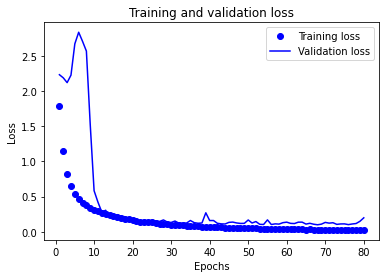

In [19]:
import matplotlib.pyplot as plt
history_dict = model_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show()

In [20]:
model2 = keras.models.load_model("checkpoint_path.keras")

In [21]:
y_predict = model2.predict(x_test1)

# TO CSV

In [22]:
import pandas as pd

In [23]:
y_predict = pd.DataFrame(y_predict, columns=['solution_' + str(i) for i in range(10)])
y_predict.head()
y_predict.index.rename('Id', inplace=True)
y_predict.to_csv('df_predictions_end.csv')